<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install wordcloud==1.8.2.2
!pip install --upgrade Pillow==9.5.0
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [4]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
display(data.info())
display(data.head(20))

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
print('Дубликатов', data.duplicated().sum())

Дубликатов 0


In [6]:
print('Пропусков:', data.isna().sum())

Пропусков: text     0
toxic    0
dtype: int64


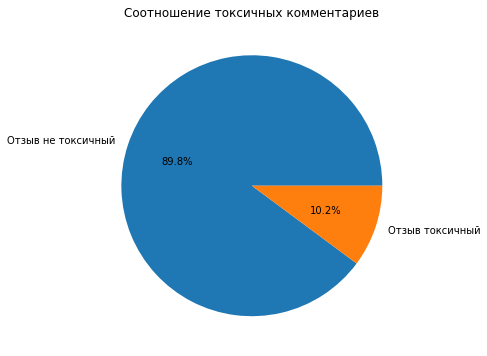

In [7]:
plt.figure(figsize=(6, 6))
plt.pie(data['toxic'].value_counts(), autopct='%1.1f%%', labels=['Отзыв не токсичный','Отзыв токсичный'])
plt.title('Соотношение токсичных комментариев')
plt.show()

In [8]:
text_raw = " ".join(data['text'])

In [9]:
wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=RANDOM_STATE, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False,
                      stopwords = nltk_stopwords.words('english')).generate(text_raw)

In [10]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")

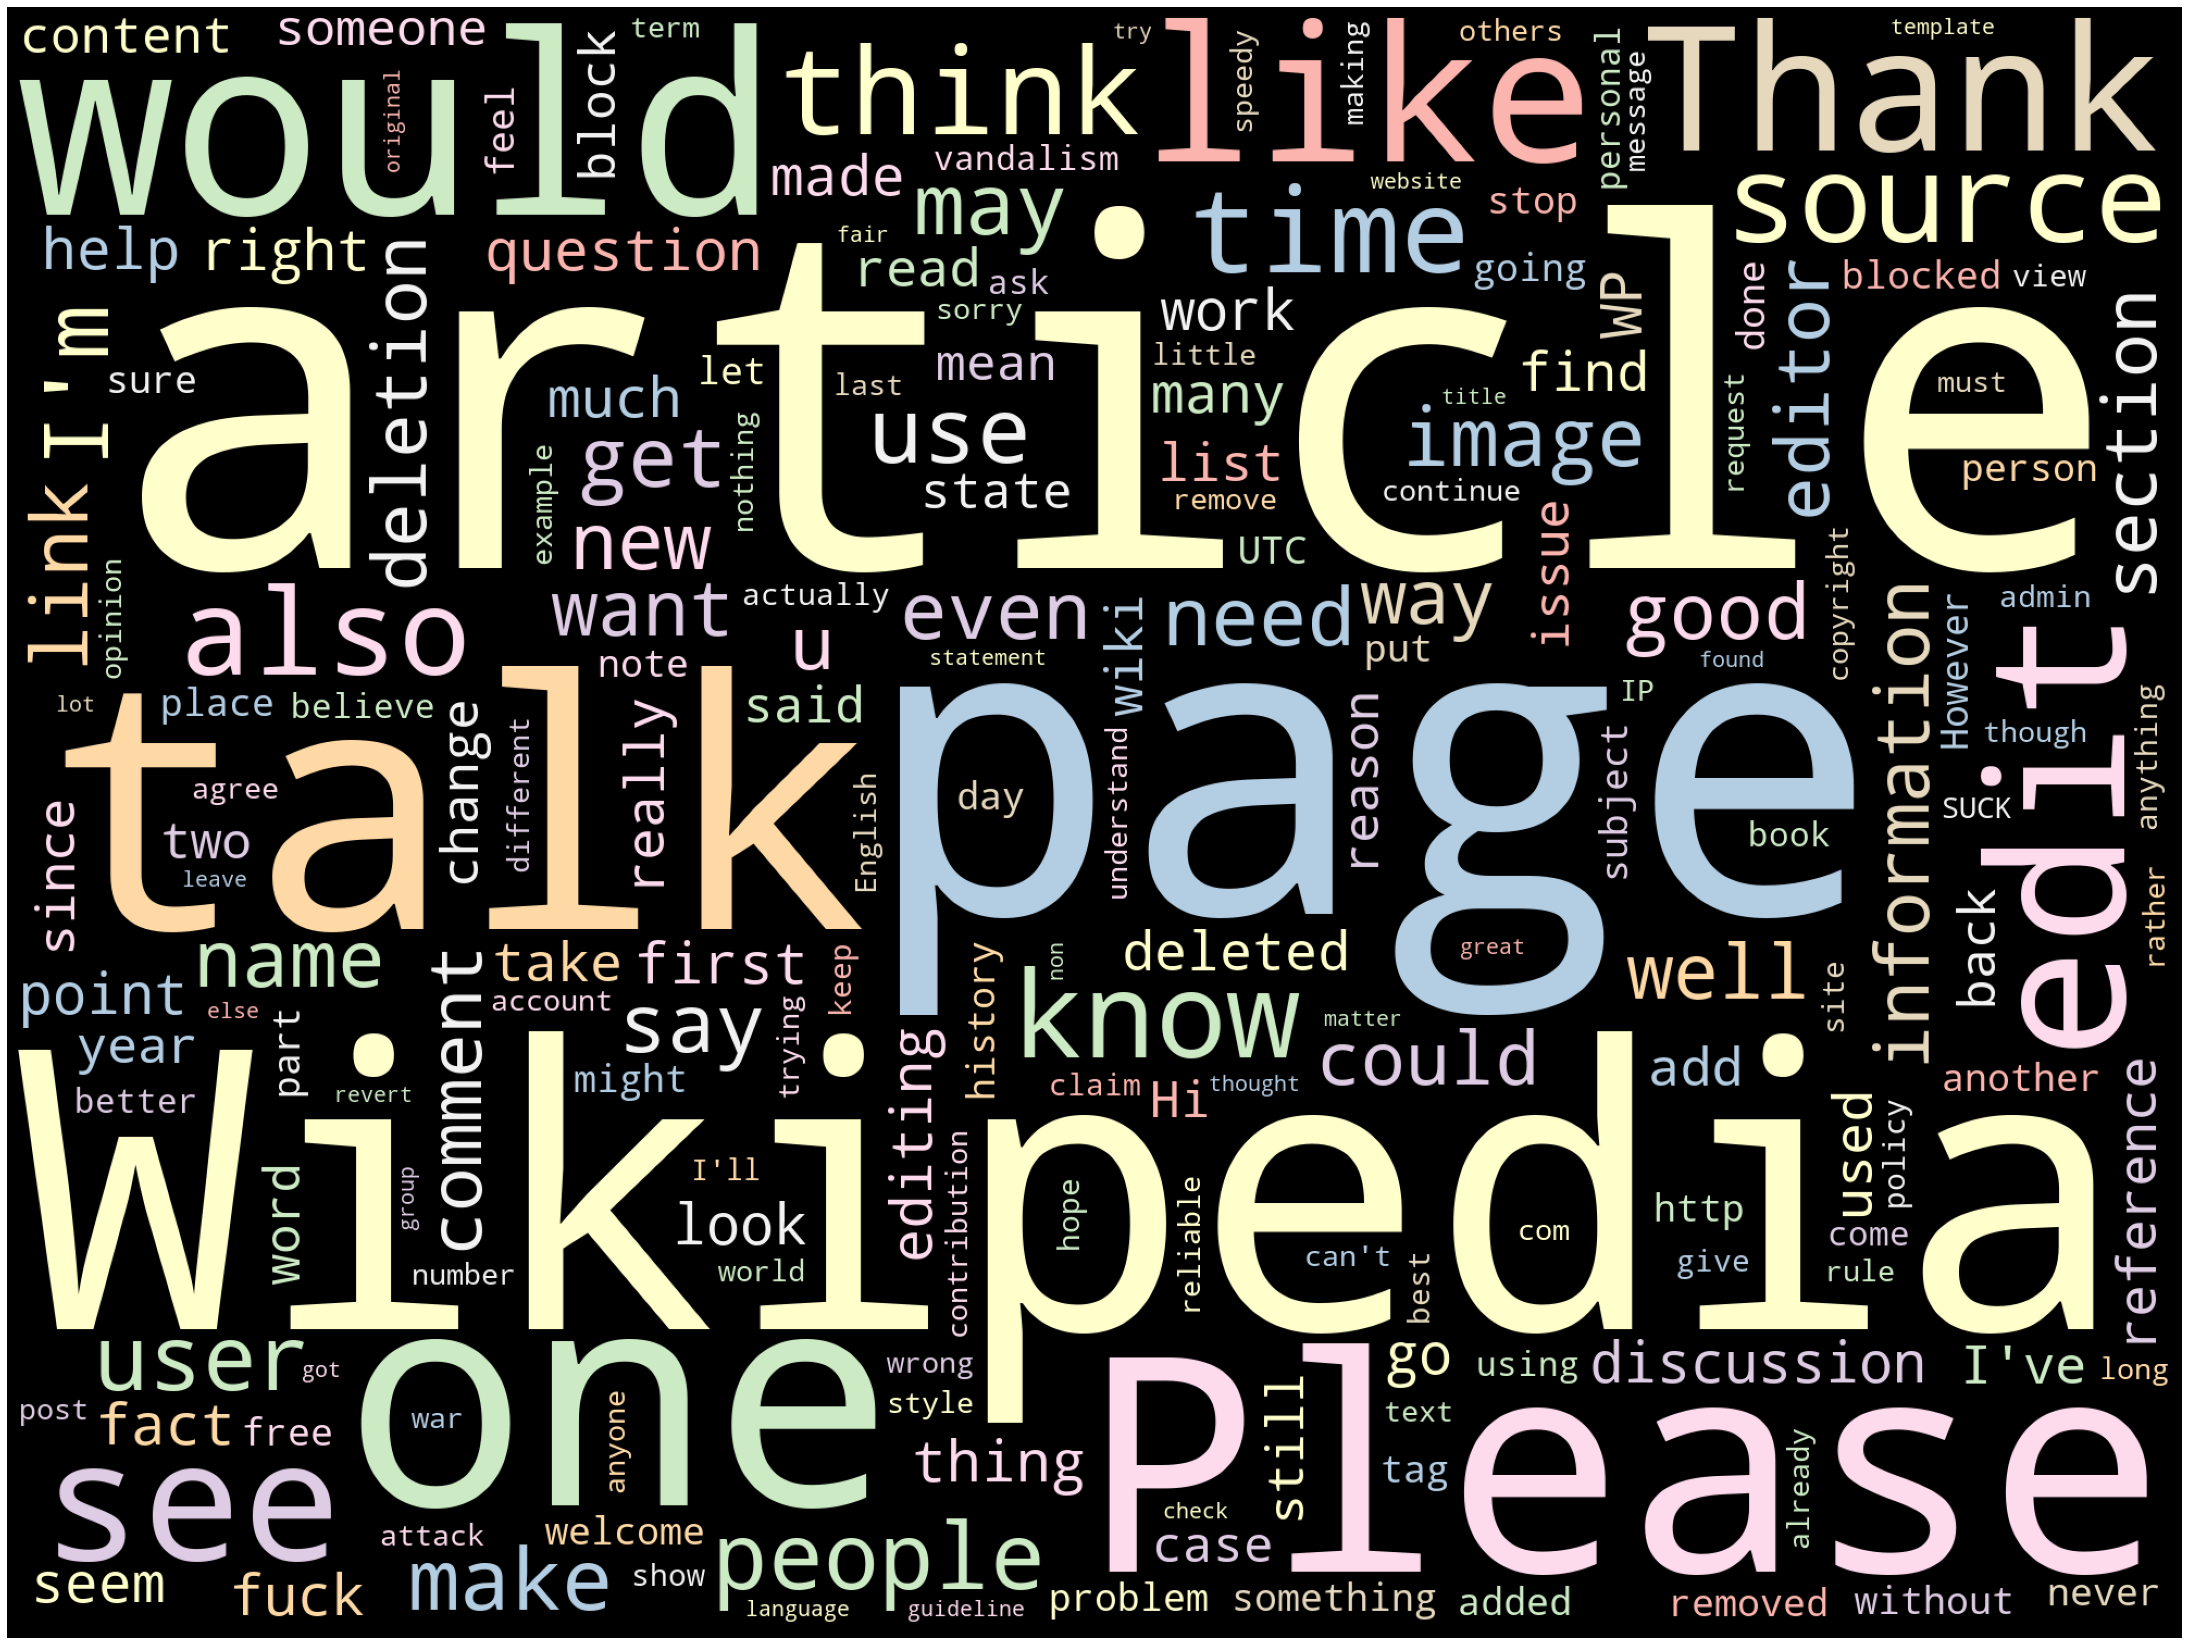

In [11]:
plot_cloud(wordcloud)

* Дупликатов и пропусков в явном виде нет. 
* Стоит исключить лишние ли \nMore\n и Explanation\n.
* Некоторые комментарии написаны только в верхнем регистре, что может помешать модерации
* Наблюдается сильный дисбаланс классов в сторону нетоксичности комментариев, надо учесть данный момент на следующих этапах
* Выгружено облако слов

In [12]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked


In [13]:
wnl = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

def lemm_text(text):
    text = [wnl.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(text)]
    return ' '.join(text)

In [14]:
nltk.download('averaged_perceptron_tagger')
df_my['text'] = df_my['text'].apply(lemm_text) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
df_my

,text
0,The strip bat be hang on their foot for best
1,you should be ashamed of yourself go work


Проверка лемматизации прошла успешно, можно использовать на основном датасете.

In [16]:
data['text'] = data['text'].progress_apply(lemm_text) 
data.head(20)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
0,Explanation Why the edits make under my userna...,0
1,D'aww ! He match this background colour I 'm s...,0
2,"Hey man , I 'm really not try to edit war . It...",0
3,`` More I ca n't make any real suggestion on i...,0
4,"You , sir , be my hero . Any chance you rememb...",0
5,"`` Congratulations from me a well , use the to...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense ' be offensive to ...,0
9,alignment on this subject and which be contrar...,0


In [17]:
features = data['text']
target = data['toxic']

features_train_0, features_test_0, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify = target)

## Обучение

In [18]:
try:
    stopwords = set(nltk_stopwords.words('english'))
except:
    pass
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
features_train = count_tf_idf.fit_transform(features_train_0)
features_test = count_tf_idf.transform(features_test_0)

### Модель CatBoost

In [24]:
%%time
cat = CatBoostClassifier(verbose=False, iterations=250)
cat.fit(features_train, target_train)
target_predict = cat.predict(features_train)
cv_f1_CBC = cross_val_score(cat,
                            features_train, 
                            target_train, 
                            cv=3, 
                            scoring='f1').mean()
print('F1 Catboost на кросс-валидации', cv_f1_CBC)

F1 Catboost на кросс-валидации 0.7311029398102771
CPU times: user 31min 34s, sys: 15.2 s, total: 31min 49s
Wall time: 31min 56s


Модель CatBoost показала значение F1 0,73

### DecisionTree

In [25]:
%%time
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
tree_parametrs = {'max_depth': range(1, 25)}

tree_grid = GridSearchCV(tree, tree_parametrs, scoring='f1', cv=3, n_jobs=-1)
tree_grid.fit(features_train, target_train)

tree.fit(features_train, target_train)
tree_cv_score = cross_val_score(tree,features_train, target_train,scoring='f1',cv=3).mean()
print('Среднее качество модели DecisionTree на кросс-валидации:', tree_cv_score)

Среднее качество модели DecisionTree на кросс-валидации: 0.6129569532626861
CPU times: user 20min 19s, sys: 2.5 s, total: 20min 22s
Wall time: 20min 24s


Модель DecisionTree показала значение F1 0,70

### Логистическая регрессия

In [26]:
%%time
regression = LogisticRegression(random_state=RANDOM_STATE, 
                                solver = 'newton-cg', 
                                class_weight='balanced')
regression_parametrs = {'C': [0.01, 1, 100]}

regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train, target_train)

regression.fit(features_train, target_train)
regression_cv_score = cross_val_score(regression,features_train, target_train,scoring='f1',cv=3).mean()
print('Среднее качество модели Логистической регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели Логистической регрессии на кросс-валидации: 0.7437189728301963
CPU times: user 3min 31s, sys: 2min 34s, total: 6min 6s
Wall time: 6min 6s


Модель логистической регрессии показала значение F1 0,74. И по времени тоже выигрывает данная модель

## Выводы

Лучше всего на кросс-валидации показала себя модель логистической регрессии, проверим метрику на тестовой:

In [27]:
regression_predictions = regression.predict(features_test)
regression_f1_test = round(f1_score(target_test, regression_predictions), 3) 
print(regression_f1_test)

0.744


Значение F1 на тестовой выборке 0,744, соизмеримо с 0,75 - значит результаты удовлетворительны.

В ходе работы был загружен и подготовлен объемный датасет с токсичными/нетоксичными комментариями
* Пропусков и дупликатов не обнаружено
* Наблюдается сильный дисбаланс классов в сторону нетоксичности комментариев, добавлена автоматическая балансировка про запуске моделей
* Выгружено облако слов, проведена лемматизация
* Обучено 3 модели Catboost, DecisionTree, LogisticRegression. Используя метрику на кросс-валидации выбрана наилучшая модель с метрикой F1 = 0,74 
* На тестовых данных получена метрика F1=0,744. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны